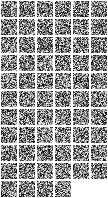

In [1]:
require 'nn'
require 'image'
require 'torch'
require 'optim'
require 'nnx'
n = nn.SpatialConvolution(1,64,16,16)
itorch.image(n.weight)

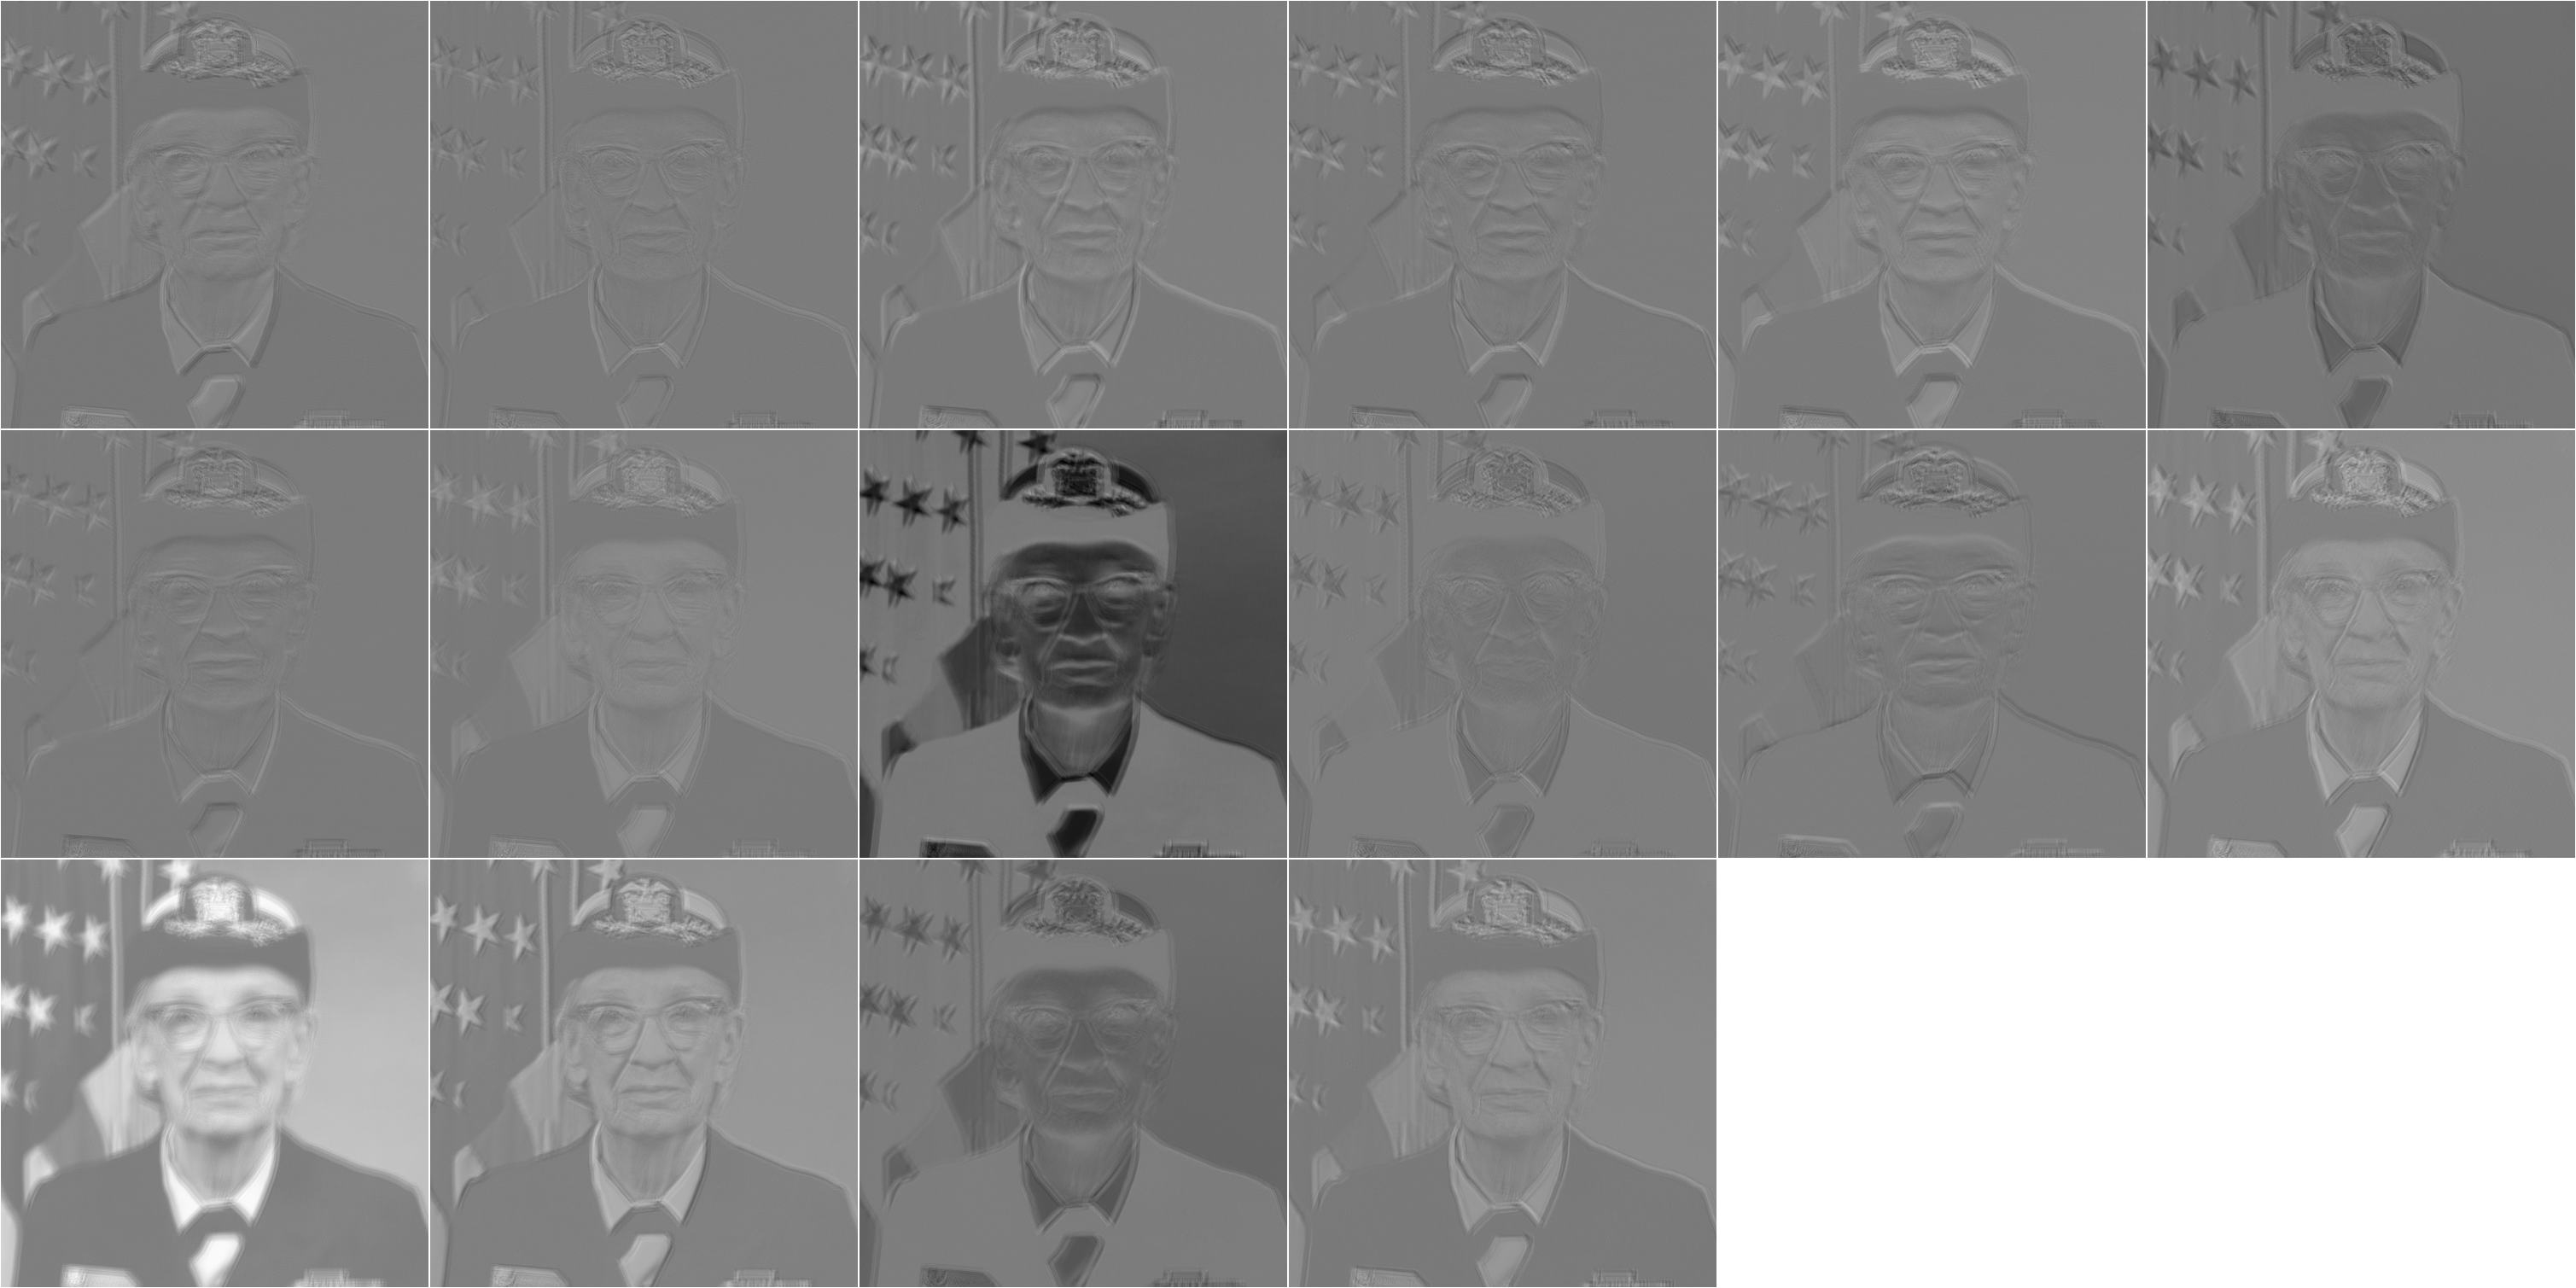

In [2]:
n = nn.SpatialConvolution(1,16,12,12)
res = n:forward(image.rgb2y(image.lena()))
itorch.image(res:view(16,1,501,501))

In [5]:
train = torch.load('mnist.t7/train_32x32.t7', 'ascii')
test = torch.load('mnist.t7/test_32x32.t7', 'ascii')

training data:	


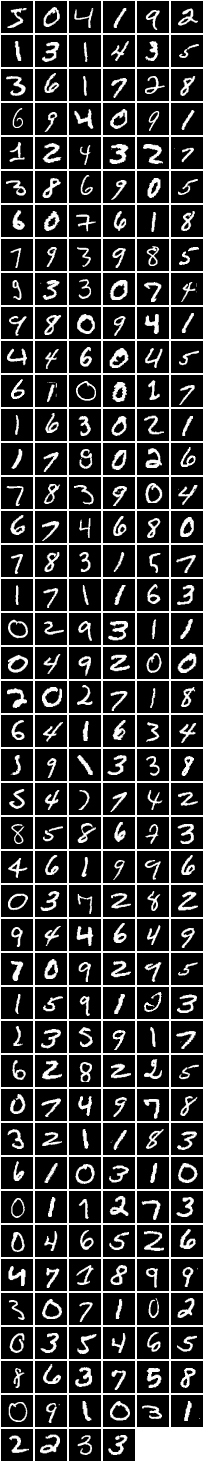

test data:	


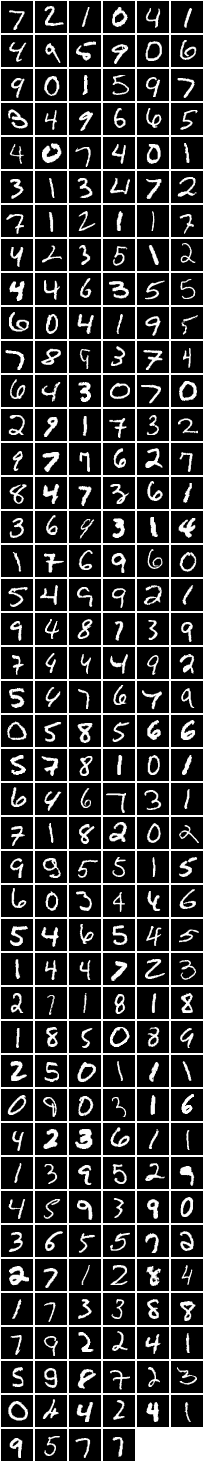

In [8]:
print('training data:')
itorch.image(train.data[{ {1,256} }])
print('test data:')
itorch.image(test.data[{ {1,256} }])

In [9]:
train

{
  data : ByteTensor - size: 60000x1x32x32
  labels : ByteTensor - size: 60000
}


In [11]:
train.labels[{{1,10}}]

  6
  1
  5
  2
 10
  3
  2
  4
  2
  5
[torch.ByteTensor of size 10]



In [12]:
train.labels[1]

6	


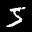

In [13]:
itorch.image(train.data[1])

In [14]:
test

{
  data : ByteTensor - size: 10000x1x32x32
  labels : ByteTensor - size: 10000
}


In [15]:
train

{
  data : ByteTensor - size: 60000x1x32x32
  labels : ByteTensor - size: 60000
}


In [16]:
model = nn.Sequential()
model:add(nn.Reshape(28*28))
model:add(nn.Linear(28*28, 30))
model:add(nn.Tanh())
model:add(nn.Linear(30, 10))
model:add(nn.LogSoftMax())


In [17]:
criterion = nn.ClassNLLCriterion()

In [18]:
sgd_params = {
   learningRate = 1e-2,
   learningRateDecay = 1e-4,
   weightDecay = 1e-3,
   momentum = 1e-4
}


In [19]:
x, dl_dx = model:getParameters()

In [30]:
step = function(batch_size)
    local current_loss = 0
    local count = 0
    local shuffle = torch.randperm(60000)
    batch_size = 200
    
    for t = 1,60000,200 do
        -- setup inputs and targets for this mini-batch
        local size = math.min(t + 200 - 1, 60000) - t
        local inputs = torch.Tensor(size, 28, 28)
        local targets = torch.Tensor(size)
        for i = 1,size do
            local input = train.data[shuffle[i+t]]
            local target = train.labels[shuffle[i+t]]
            -- if target == 0 then target = 10 end
            inputs[i] = input
            targets[i] = target
        end
        targets:add(1)
        
        local feval = function(x_new)
            -- reset data
            if x ~= x_new then x:copy(x_new) end
            dl_dx:zero()

            -- perform mini-batch gradient descent
            local loss = criterion:forward(model:forward(inputs), targets)
            model:backward(inputs, criterion:backward(model.output, targets))

            return loss, dl_dx
        end
        
        _, fs = optim.sgd(feval, x, sgd_params)
        -- fs is a table containing value of the loss function
        -- (just 1 value for the SGD optimization)
        count = count + 1
        current_loss = current_loss + fs[1]
    end

    -- normalize loss
    return current_loss / count
end


In [21]:
eval = function(dataset, batch_size)
    local count = 0
    batch_size = 200
    
    for i = 1,60000,200 do
        local size = math.min(i + 200 - 1, dataset.size) - i
        local inputs = dataset.data[{{i,i+size-1}}]
        local targets = dataset.labels[{{i,i+size-1}}]:long()
        local outputs = model:forward(inputs)
        local _, indices = torch.max(outputs, 2)
        indices:add(-1)
        local guessed_right = indices:eq(targets):sum()
        count = count + guessed_right
    end

    return count / dataset.size
end


In [22]:
max_iters = 30

In [38]:
do
    local last_accuracy = 0
    local decreasing = 0
    local threshold = 1 -- how many deacreasing epochs we allow
    for i = 1,max_iters do
        local loss = step(200)
        print(string.format('Epoch: %d Current loss: %4f', i, loss))
        local accuracy = eval(validationset)
        print(string.format('Accuracy on the validation set: %4f', accuracy))
        if accuracy < last_accuracy then
            if decreasing > threshold then break end
            decreasing = decreasing + 1
        else
            decreasing = 0
        end
        last_accuracy = accuracy
    end
end

invalid arguments: nil 
expected arguments: [*DoubleTensor*] [Generator] long
stack traceback:
	[C]: at 0x7fd639cdc900
	[C]: in function 'randperm'
	[string "step = function(batch_size)..."]:4: in function 'step'
	[string "do..."]:6: in main chunk
	[C]: in function 'xpcall'
	...e/thesidjway/torch/install/share/lua/5.1/itorch/main.lua:210: in function <...e/thesidjway/torch/install/share/lua/5.1/itorch/main.lua:174>
	...e/thesidjway/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	...hesidjway/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	...hesidjway/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	...hesidjway/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...e/thesidjway/torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 